In [4]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role

np.random.seed(1)

Matplotlib is building the font cache; this may take a moment.


1


In [5]:
prefix = "sagemaker/DEMO-deepar"

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [10]:
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)

#### Create Synthetic Data for Now


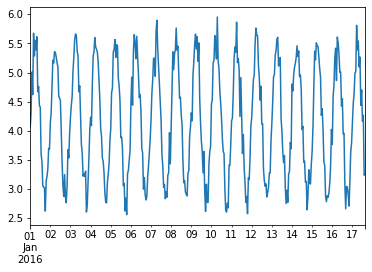

In [7]:
freq = "H"
prediction_length = 48
context_length = 72
t0 = "2016-01-01 00:00:00"
data_length = 400
num_ts = 200
period = 24

time_series = []
for k in range(num_ts):
    level = 10 * np.random.rand()
    seas_amplitude = (0.1 + 0.3 * np.random.rand()) * level
    sig = 0.05 * level  # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude * np.sin(time_ticks * (2 * np.pi) / period)
    noise = sig * np.random.randn(data_length)
    data = source + noise
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))
    
time_series[0].plot()
plt.show()

### Perform Train/Test Split Based on Time, Leave out Trailing 48 data points

In [8]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

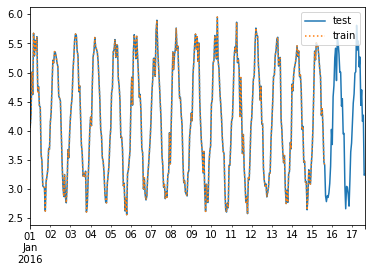

In [9]:
time_series[0].plot(label="test")
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.show()

In [11]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [12]:
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in time_series:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

### Initialize Estimator

In [13]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="DEMO-deepar",
    output_path=f"s3://{s3_output_path}",
)

In [14]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

In [ ]:
estimator.set_hyperparameters(**hyperparameters)

### Training

In [16]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

2023-01-15 04:37:54 Starting - Starting the training job...
2023-01-15 04:38:17 Starting - Preparing the instances for trainingProfilerReport-1673757474: InProgress
......
2023-01-15 04:39:17 Downloading - Downloading input data...
2023-01-15 04:39:37 Training - Downloading the training image......
2023-01-15 04:40:53 Training - Training image download completed. Training in progress...Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[01/15/2023 04:41:06 INFO 139683562841920] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.

[01/15/2023 04:41:14 INFO 139683562841920] processed a total of 300 examples
#metrics {"StartTime": 1673757672.8778274, "EndTime": 1673757674.3644521, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1486.5620136260986, "count": 1, "min": 1486.5620136260986, "max": 1486.5620136260986}}}
[01/15/2023 04:41:14 INFO 139683562841920] #throughput_metric: host=algo-1, train throughput=201.79284647936134 records/second
[01/15/2023 04:41:14 INFO 139683562841920] #progress_metric: host=algo-1, completed 20.0 % of epochs
[01/15/2023 04:41:14 INFO 139683562841920] #quality_metric: host=algo-1, epoch=3, train loss <loss>=0.2973672069609165
[01/15/2023 04:41:14 INFO 139683562841920] best epoch loss so far
[01/15/2023 04:41:14 INFO 139683562841920] Saved checkpoint to "/opt/ml/model/state_cead14db-babe-4185-b5e1-ee24295c3895-0000.params"
#metrics {"StartTime": 1673757674.3645258, "EndTime": 1673757674.403719, "Dimensions": {"Algo

[01/15/2023 04:41:24 INFO 139683562841920] Epoch[10] Batch[0] avg_epoch_loss=-0.017987
[01/15/2023 04:41:24 INFO 139683562841920] #quality_metric: host=algo-1, epoch=10, batch=0 train loss <loss>=-0.0179867185652256
[01/15/2023 04:41:24 INFO 139683562841920] Epoch[10] Batch[5] avg_epoch_loss=-0.070195
[01/15/2023 04:41:24 INFO 139683562841920] #quality_metric: host=algo-1, epoch=10, batch=5 train loss <loss>=-0.0701951663941145
[01/15/2023 04:41:24 INFO 139683562841920] Epoch[10] Batch [5]#011Speed: 233.62 samples/sec#011loss=-0.070195
[01/15/2023 04:41:25 INFO 139683562841920] processed a total of 295 examples
#metrics {"StartTime": 1673757684.001994, "EndTime": 1673757685.4992979, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1496.492624282837, "count": 1, "min": 1496.492624282837, "max": 1496.492624282837}}}
[01/15/2023 04:41:25 INFO 139683562841920] #throughput_metric: host=algo-1, train throughput=197.10910

[01/15/2023 04:41:34 INFO 139683562841920] processed a total of 317 examples
#metrics {"StartTime": 1673757693.2691548, "EndTime": 1673757694.7979732, "Dimensions": {"Algorithm": "AWS/DeepAR", "Host": "algo-1", "Operation": "training"}, "Metrics": {"update.time": {"sum": 1528.3758640289307, "count": 1, "min": 1528.3758640289307, "max": 1528.3758640289307}}}
[01/15/2023 04:41:34 INFO 139683562841920] #throughput_metric: host=algo-1, train throughput=207.3925991600065 records/second
[01/15/2023 04:41:34 INFO 139683562841920] #progress_metric: host=algo-1, completed 85.0 % of epochs
[01/15/2023 04:41:34 INFO 139683562841920] #quality_metric: host=algo-1, epoch=16, train loss <loss>=-0.08533735051751137
[01/15/2023 04:41:34 INFO 139683562841920] loss did not improve
[01/15/2023 04:41:35 INFO 139683562841920] Epoch[17] Batch[0] avg_epoch_loss=-0.090847
[01/15/2023 04:41:35 INFO 139683562841920] #quality_metric: host=algo-1, epoch=17, batch=0 train loss <loss>=-0.09084665775299072
[01/15/202


2023-01-15 04:42:18 Uploading - Uploading generated training model
2023-01-15 04:42:18 Completed - Training job completed
Training seconds: 182
Billable seconds: 182


### Create Endpoint for Inference (make sure to delete at the end!)

In [18]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

-------!

#### Utils

In [19]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [20]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Predict

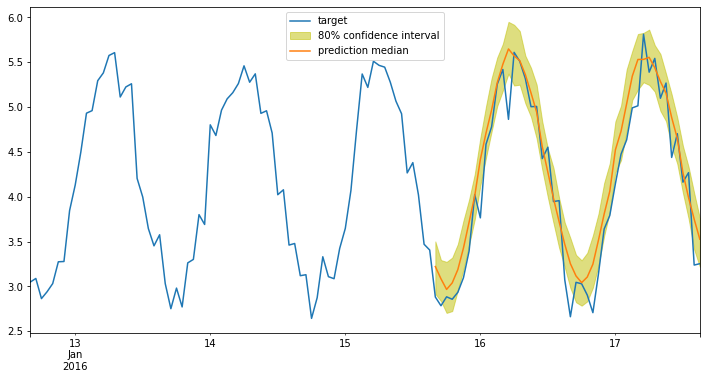

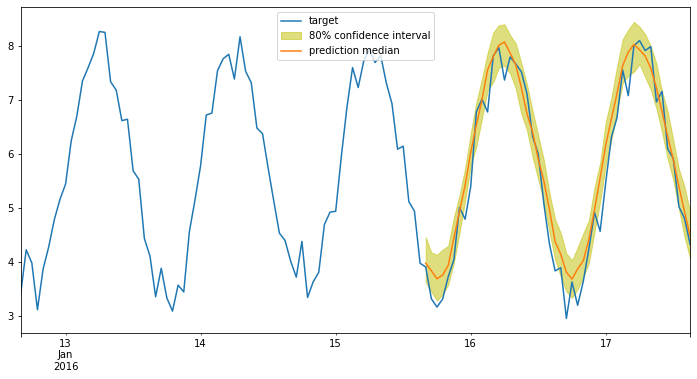

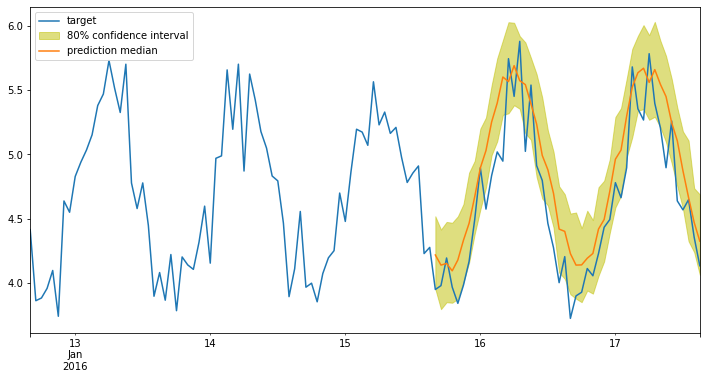

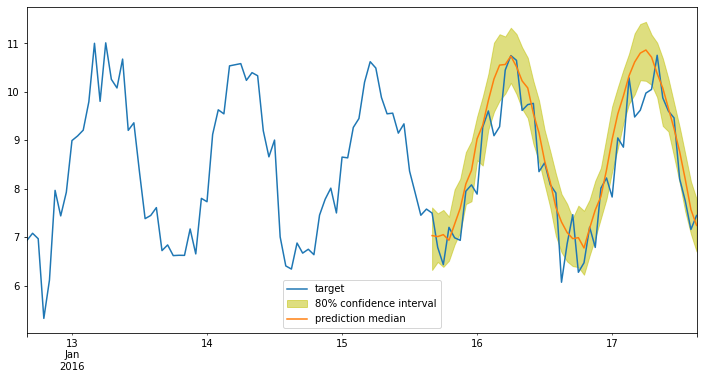

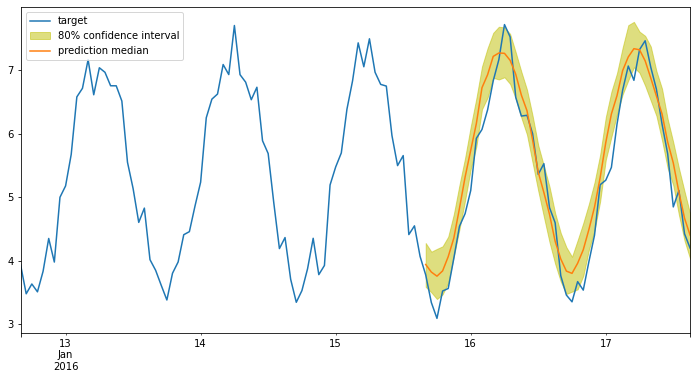

In [21]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series[:5]

for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

### Delete Me!

In [28]:
sagemaker_session.delete_endpoint(endpoint_name)

ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:579452476622:endpoint/demo-deepar-2023-01-15-04-37-54-226".